In [1]:
import os
import sys
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import neptune
from neptune.utils import stringify_unsupported
from ruamel.yaml import YAML
from torch.amp import GradScaler, autocast
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from torchvision.transforms import RandomRotation, RandomCrop
from torchvision.transforms.functional import InterpolationMode
from tqdm import tqdm
import torch.nn.functional as F


from multiplex_model.data import DatasetFromTIFF, PanelBatchSampler, TestCrop
from multiplex_model.losses import nll_loss
from multiplex_model.utils import ClampWithGrad, plot_reconstructs_with_uncertainty, get_scheduler_with_warmup
from multiplex_model.modules import MultiplexAutoencoder
from multiplex_model.run_utils import build_run_name_suffix, SLURM_JOB_ID


In [26]:
import pandas as pd
df = pd.read_pickle("/raid/immucan/immuw/data/NSCLC_vq_embeds.pkl")

In [27]:
df.head()

,img_path,panel,coords0,coords1,embeddings,split
0,/raid/immucan/IMC/NSCLC2/IMC1/unzipped/train/L...,1,"(0, 0)","(112, 112)","[[38, 51, 34, 105, 34, 219, 34, 34, 32, 128, 2...",train
1,/raid/immucan/IMC/NSCLC2/IMC1/unzipped/train/L...,1,"(0, 112)","(112, 224)","[[233, 89, 153, 153, 219, 219, 153, 125, 34, 3...",train
2,/raid/immucan/IMC/NSCLC2/IMC1/unzipped/train/L...,1,"(0, 224)","(112, 336)","[[120, 156, 176, 148, 9, 203, 135, 126, 176, 2...",train
3,/raid/immucan/IMC/NSCLC2/IMC1/unzipped/train/L...,1,"(0, 336)","(112, 448)","[[135, 124, 59, 129, 144, 124, 152, 203, 229, ...",train
4,/raid/immucan/IMC/NSCLC2/IMC1/unzipped/train/L...,1,"(0, 448)","(112, 560)","[[134, 134, 134, 134, 134, 83, 134, 134, 134, ...",train


In [28]:
df.dtypes

img_path      object
panel          int64
coords0       object
coords1       object
embeddings    object
split         object
dtype: object

In [29]:
type(df["embeddings"].iloc[0])

numpy.ndarray

In [3]:
# load model ckpt
# ckpt_path = "checkpoints/checkpoint-IM-41-epoch_149.pth"
# ckpt_path = "/raid/szlukasik/immu-vis/multiplex-image-model/checkpoints/checkpoint-EquivariantConvnext_20250827_002044_J1611-epoch_999.pth"
ckpt_path = "/raid/szlukasik/immu-vis/multiplex-image-model/checkpoints/checkpoint-EquivariantConvnext_20251004_191704_J2206-epoch_179.pth"

state_dict = torch.load(ckpt_path, map_location='cpu')

/tmp/ipykernel_714092/704008424.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_location='cpu')


In [2]:
import os
import sys
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import neptune
from neptune.utils import stringify_unsupported
from ruamel.yaml import YAML
from torch.amp import GradScaler, autocast
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from torchvision.transforms import RandomRotation, RandomCrop
from tqdm import tqdm
from torchvision import transforms

# ModuleNotFoundError: No module named 'multiplex_model'
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from multiplex_model.data import DatasetFromTIFF, PanelBatchSampler, TestCrop
from multiplex_model.losses import nll_loss
from multiplex_model.utils import ClampWithGrad, plot_reconstructs_with_uncertainty, get_scheduler_with_warmup
from multiplex_model.modules import MultiplexAutoencoder
from multiplex_model.run_utils import build_run_name_suffix, SLURM_JOB_ID


from src_from_rudy.utils import setup_seeds, setup_clearml, ChainDataLoader
from src_from_rudy.augmentations import ArcsinhNormalize, MinMaxNormalize, ButterworthFilter, GlobalNormalize, SelectMarkers
from src_from_rudy.config.autoencoder_cells import Config as CellsConfig
from src_from_rudy.config.multiplex_vit_no_bottleneck_autoencoder import Config as TissuesConfig
from src_from_rudy.constants import LOGDIR, IMC_PANEL2_DATA_DIR, PANEL_1_MARKER_NAMES, IMC_PANEL1_DATA_DIR, HALEY_GLIO, DANENBERG_BREAST_DIR, REQUIRED_IMG_SHAPES
from src_from_rudy.datasets.imc_datasets import CellPatchesDataModule, WholeSlidesDataModule, ContrastiveTissuePatchesDataModule, TissuePatchesDataModule



CONFIG_OVERRIDES = {
    "device": "cpu",  # Change to 'cuda:0' if using GPU
    "panel_config": "configs/all_panels_config.yaml",
    "tokenizer_config": "configs/all_markers_tokenizer.yaml"
}

global TOKENIZER, INV_TOKENIZER, PANEL_CONFIG

def apply_overrides(config, overrides):
    for key, value in overrides.items():
        if key in config:
            config[key] = value
        else:
            print(f"Warning: {key} not found in config, skipping override.")
    return config

def load_configuration(config_path):
    yaml = YAML(typ='safe')
    with open(config_path, 'r') as f:
        config = yaml.load(f)
    
    with open("secrets/neptune.yaml", 'r') as f:
        secrets = yaml.load(f)
    config = apply_overrides(config, CONFIG_OVERRIDES)

    prefix = config.get("run_prefix", "").strip()         # empty by default
    suffix = build_run_name_suffix()                               # always unique
    run_name = f"{prefix}_{suffix}" if prefix else suffix

    run = neptune.init_run(
        name=run_name,
        project=secrets['neptune_project'],
        api_token=secrets['neptune_api_token'],
        tags=config['tags'],
    )

    device = config['device']
    print(f'Using device: {device}')

    SIZE = config['input_image_size']
    print(f"INPUT IMAGE SIZE: {SIZE}")
    BATCH_SIZE = config['batch_size']
    NUM_WORKERS = config['num_workers']

    PANEL_CONFIG = YAML().load(open(config['panel_config']))
    TOKENIZER = YAML().load(open(config['tokenizer_config']))
    print(f"Training on datasets: {PANEL_CONFIG['datasets']}")
    MARKERS_SET = {k for dataset in PANEL_CONFIG['datasets'] for k in PANEL_CONFIG['markers'][dataset]}
    print(f"Markers set: {MARKERS_SET}")
    print(f"Number of markers: {len(MARKERS_SET)}")
    TOKENIZER = {k: v for k, v in zip(MARKERS_SET, range(len(MARKERS_SET)))}
    INV_TOKENIZER = {v: k for k, v in TOKENIZER.items()}

    train_transform = Compose([
        # RandomRotation(180),
        TestCrop(SIZE[0]),
    ])

    test_transform = TestCrop(SIZE[0])

    train_dataset = DatasetFromTIFF(
        panels_config=PANEL_CONFIG,
        split='train',
        marker_tokenizer=TOKENIZER,
        transform=train_transform,
        use_median_denoising=False,
        use_butterworth_filter=True
    )

    test_dataset = DatasetFromTIFF(
        panels_config=PANEL_CONFIG,
        split='test',
        marker_tokenizer=TOKENIZER,
        transform=test_transform,
        use_median_denoising=False,
        use_butterworth_filter=True
    )

    train_batch_sampler = PanelBatchSampler(train_dataset, BATCH_SIZE)
    test_batch_sampler = PanelBatchSampler(test_dataset, BATCH_SIZE, shuffle=False)

    train_dataloader = DataLoader(train_dataset, batch_sampler=train_batch_sampler, num_workers=NUM_WORKERS)
    test_dataloader = DataLoader(test_dataset, batch_sampler=test_batch_sampler, num_workers=NUM_WORKERS)

    model_config = {
        'num_channels': len(TOKENIZER),
        'superkernel_config': config['superkernel'],
        'encoder_config': config['encoder'],
        'decoder_config': config['decoder'],
    }

    if config["model_type"] == "EquivariantConvnext":
        from multiplex_model.equivariant_modules import EquivariantMultiplexAutoencoder
        model = EquivariantMultiplexAutoencoder(**model_config).to(device)
    elif config["model_type"] == "Convnext":
        model = MultiplexAutoencoder(**model_config).to(device)

    print(f'Model created with config: {model_config}')
    print(f'Model has {sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable parameters')
    print(f'Model: {model}')
    print(f'Training on {len(train_dataloader.dataset)} training samples and {len(test_dataloader.dataset)} test samples')
    print(f'Batch size: {BATCH_SIZE}, Number of workers: {NUM_WORKERS}')
    return model, train_dataloader, test_dataloader, TOKENIZER, INV_TOKENIZER, config

config_path = "/raid/szlukasik/immu-vis/multiplex-image-model/train_masked_equivariant_config.yaml"
model, train_dataloader, test_dataloader, TOKENIZER, INV_TOKENIZER, config = load_configuration(config_path)

[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs-legacy.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/immu-vis/patch-autoencoders/e/IM-365
Using device: cpu
INPUT IMAGE SIZE: [113, 113]
Training on datasets: ['ajaib', 'bc2', 'bengsch', 'bowen-lynch', 'cho_2025', 'cords', 'cords-fibro', 'damond-lung', 'danenberg', 'ehret_2025_p1', 'ehret_2025_p2', 'einhaus_2025', 'haley_glio', 'hn', 'hoch-protein', 'hoch-rna', 'jackson-basel', 'jackson-zurich', 'kucukkose', 'nsclc2-panel1', 'nsclc2-panel2', 'ohara', 'steenbuck-immune', 'steenbuck-islets', 'susman', 'xu']
Markers set: {'ADAR1', 'Proglucagon', 'CD54', 'pSTAT3', 'CD15', 'GLUT1', 'TOX2', 'CD34', 'ERK', 'Fibronectin', 'Bcl2', 'HER3', 'CXCL9', 'GPA33', 'AKT', 'HER2 (3B5)', 'Hexokinase I', 'CD33', 'VCAM1', 'PTEN', 'TIGIT', 'CD94', 'CCL2', 'TMEM173', 'CD109', 'FOXA2', 'GrzB', 'panCK', 'DLL3', 'PM2', 'CD47', 'SNAI1', 'CD137', 'CCL8', 'ICOS', 'DapB', 'PIN', 'CHI3L1', 'p53', 'vWF', 'CTLA-4', 'CCR2', 'Histone H3 - t', 'LAMP3', 'AMY1A', 'PP', 'HLADR', 'IL17a', 'pERK', '

In [2]:

config_path = "/raid/szlukasik/immu-vis/multiplex-image-model/configs/train_masked_config_base.yaml"
yaml = YAML(typ='safe')
with open(config_path, 'r') as f:
    config = yaml.load(f)


In [31]:
config['from_checkpoint'] = "models/model-UN-232-ds_depend_clip.pth"

In [9]:
PANEL_CONFIG = YAML().load(open(config['panel_config']))
TOKENIZER = YAML().load(open(config['tokenizer_config']))
model_config = {
        'num_channels': len(TOKENIZER),
        'superkernel_config': config['superkernel'],
        'encoder_config': config['encoder'],
        'decoder_config': config['decoder'],
    }
model = MultiplexAutoencoder(**model_config)

In [6]:
PANEL_CONFIG = YAML().load(open(config['panel_config']))
PANEL_CONFIG["datasets"] = ["nsclc2-panel1"]
# TOKENIZER = YAML().load(open(config['tokenizer_config']))
# model_config = {
#         'num_channels': len(TOKENIZER),
#         'superkernel_config': config['superkernel'],
#         'encoder_config': config['encoder'],
#         'decoder_config': config['decoder'],
#     }
# model = MultiplexAutoencoder(**model_config)

In [4]:
device = "cuda:3"

In [4]:
# checkpoint = torch.load(config['from_checkpoint'], map_location=device)
model.load_state_dict(state_dict['model_state_dict'])   
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

<All keys matched successfully>

In [7]:
train_dataset = DatasetFromTIFF(
    panels_config=PANEL_CONFIG,
    split='train',
    marker_tokenizer=TOKENIZER,
    transform=Compose([]),
    use_median_denoising=False,
    use_butterworth_filter=True,
    use_minmax_normalization=False,
    use_clip_normalization=True
)

In [8]:
test_dataset = DatasetFromTIFF(
    panels_config=PANEL_CONFIG,
    split='test',
    marker_tokenizer=TOKENIZER,
    transform=Compose([]),
    use_median_denoising=False,
    use_butterworth_filter=True,
    use_minmax_normalization=False,
    use_clip_normalization=True
)

In [9]:
train_dataloader = DataLoader(train_dataset)
test_dataloader = DataLoader(test_dataset)

In [13]:
panel_1_markers = PANEL_CONFIG['markers']['nsclc2-panel1']
panel_1_indices = [TOKENIZER.get(marker) for marker in panel_1_markers]
panel_1_markers

['B2M', 'Carbonic Anhydrase', 'CD11c', 'CD14', 'CD15', 'CD16', 'CD163', 'CD20', 'CD206', 'CD27', 'CD3', 'CD303', 'CD33', 'CD38', 'CD4', 'CD40', 'CD45RA', 'CD45RO', 'CD68', 'CD7', 'CD8a', 'cl.PARP', 'DNA1', 'DNA2', 'Ecad', 'FOXP3', 'GrzB', 'Histone H3', 'HLADR', 'ICOS', 'Ido1', 'Ki67', 'LAG3', 'MPO', 'PD1', 'PDGFRb', 'PDL1', 'SMA', 'TCF7', 'VISTA']

In [15]:
model = model.to(device)

In [16]:
# images are of shape (B, C, H, W) where H, W = 600 We want to process a grid of distinct patches of size 112x112
results_images = {}
for idx, (img, channel_ids, panel_idx, img_path) in enumerate(tqdm(test_dataloader)):
    # assert that shape is 600x600
    # assert img.shape[-2:] == (600, 600), f"Image shape is {img.shape[-2:]}, expected (600, 600)"
    if img.shape[-2:] != (600, 600):
        print(f"Skipping image {img_path} with shape {img.shape[-2:]}, expected (600, 600)")
        continue
    img = img.to(device).to(torch.float32)
    # print(img.shape)
    # I want to process the image in a following way - [0:112, 0:112], [0:112, 112:224], ... [0:112, 488:600]
    patches_indices = [
        [(slice(i, i + 112), slice(j, j + 112)) for j in range(0, 560, 112)] + [(slice(i, i + 112), slice(488, 600))]
        for i in range(0, 560, 112)
    ] + [[(slice(488, 600), slice(j, j + 112)) for j in range(0, 560, 112)] + [(slice(488, 600), slice(488, 600))]]
    patches_indices_flat = [item for sublist in patches_indices for item in sublist]
    # assert that for all patches the shape is (B, C, 112, 112)
    # for h_idx, w_idx in patches_indices_flat:
    #     patch = img[:, :, h_idx, w_idx]
    #     assert patch.shape[-2:] == (112, 112), f"Patch shape is {patch.shape[-2:]}, expected (112, 112)"
    # print(patches_indices_flat[-1])
    # break
    results_patches = []
    for patch_idx, (h_idx, w_idx) in enumerate(patches_indices_flat):
        results_rotatations = {}
        for rotation, flip in ((0, 1), (90, 1), (180, 1), (270, 1)):
            for flip in range(flip + 1):
                patch = img[:, :, h_idx, w_idx]
                if rotation > 0:
                    patch = torch.rot90(patch, k=rotation // 90, dims=[-2, -1])
                if flip > 0:
                    patch = torch.flip(patch, dims=[-1])
                
                encoded_indices = torch.tensor([panel_1_indices]).to(device)
                outputs = model(patch, encoded_indices,  encoded_indices, True)
                embedding = outputs["features"][-1]
                if flip > 0:
                    embedding = torch.flip(embedding, dims=[-1])
                if rotation > 0:
                    embedding = torch.rot90(embedding, k=(- rotation // 90), dims=[-2, -1])
                mi, logsigma = outputs["output"].unbind(dim=-1)
                # print(mi.shape, logsigma.shape, patch.shape)
                mi = torch.sigmoid(mi)
                loss = nll_loss(patch, mi, logsigma)
                mae = torch.abs(patch - mi).mean()

                mae_between_embeddings = torch.tensor(0.0)
                if rotation > 0 and flip == 0:
                    org_embedding = torch.tensor(results_rotatations["r0_nf"]['embedding']).to(device)
                    mae_between_embeddings = ((embedding -  org_embedding) ** 2).mean() / (org_embedding ** 2).mean()
                # print(f"Patch {patch_idx} Loss: {loss.item():.4f}, MAE: {mae.item():.4f}")

                result = {
                    "embedding": embedding.detach().cpu().numpy(),
                    "loss": loss.item(),
                    "mae": mae.item(),
                    "rotation_error": mae_between_embeddings.item(),
                }
                key = f"r{rotation}_{'f' if flip > 0 else 'nf'}"
                results_rotatations[key] = result
        results_rotatations["position"] = (h_idx, w_idx)
        results_patches.append(results_rotatations) 
    results_images[img_path] = results_patches
# results_images

# test took 5m7s

  3%|███▏                                                                                            | 5/149 [02:20<54:25, 22.68s/it]

Skipping image ('/raid/immucan/immuvis_splits/test/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4364.tiff',) with shape torch.Size([578, 804]), expected (600, 600)


 16%|███████████████▎                                                                               | 24/149 [12:57<51:51, 24.89s/it]

Skipping image ('/raid/immucan/immuvis_splits/test/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4267.tiff',) with shape torch.Size([500, 500]), expected (600, 600)


 19%|██████████████████▍                                                                            | 29/149 [15:19<46:29, 23.25s/it]

Skipping image ('/raid/immucan/immuvis_splits/test/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4504.tiff',) with shape torch.Size([599, 600]), expected (600, 600)


 25%|███████████████████████▌                                                                       | 37/149 [19:28<45:13, 24.23s/it]

Skipping image ('/raid/immucan/immuvis_splits/test/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4245.tiff',) with shape torch.Size([500, 500]), expected (600, 600)


 36%|█████████████████████████████████▊                                                             | 53/149 [28:20<39:52, 24.92s/it]

Skipping image ('/raid/immucan/immuvis_splits/test/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4349.tiff',) with shape torch.Size([599, 600]), expected (600, 600)


 50%|███████████████████████████████████████████████▊                                               | 75/149 [40:46<31:07, 25.23s/it]

Skipping image ('/raid/immucan/immuvis_splits/test/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4338.tiff',) with shape torch.Size([600, 599]), expected (600, 600)


 68%|████████████████████████████████████████████████████████████████▎                             | 102/149 [56:07<19:42, 25.16s/it]

Skipping image ('/raid/immucan/immuvis_splits/test/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4306.tiff',) with shape torch.Size([599, 600]), expected (600, 600)


 69%|████████████████████████████████████████████████████████████████▉                             | 103/149 [56:08<13:43, 17.91s/it]

Skipping image ('/raid/immucan/immuvis_splits/test/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4316.tiff',) with shape torch.Size([600, 599]), expected (600, 600)


 95%|███████████████████████████████████████████████████████████████████████████████████████     | 141/149 [1:17:59<03:19, 24.96s/it]

Skipping image ('/raid/immucan/immuvis_splits/test/nsclc2-panel1/imgs/full.immucan-p1.nsclc2.4503.tiff',) with shape torch.Size([434, 452]), expected (600, 600)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [1:22:47<00:00, 33.34s/it]


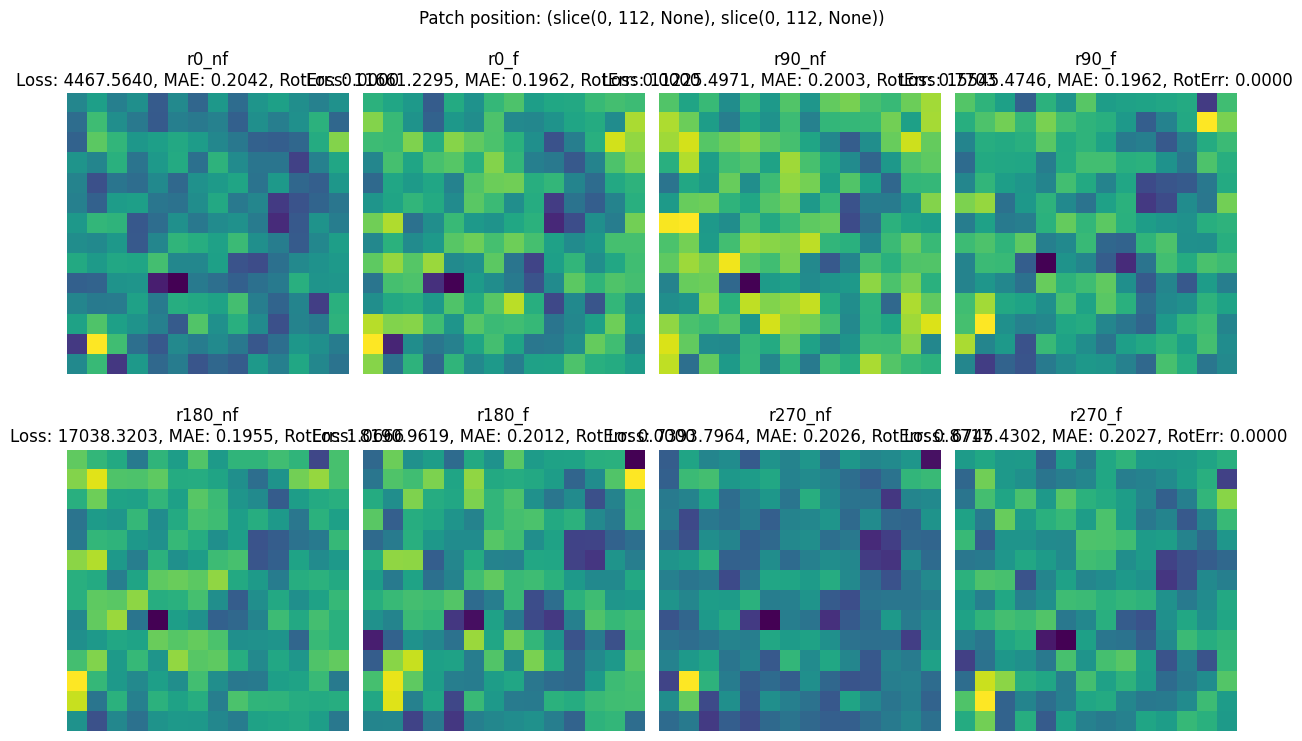

In [45]:
# plot example embeddings
import matplotlib.pyplot as plt

for patch in results_images[list(results_images.keys())[0]]:
    plt.figure(figsize=(12, 8))
    for i, (key, value) in enumerate(patch.items()):
        if key == "position":
            continue
        embedding = value["embedding"].squeeze()
        plt.subplot(2, 4, i + 1)
        plt.imshow(embedding[0], cmap='viridis')
        plt.title(f"{key}\nLoss: {value['loss']:.4f}, MAE: {value['mae']:.4f}, RotErr: {value['rotation_error']:.4f}")
        plt.axis('off')
    plt.suptitle(f"Patch position: {patch['position']}")
    plt.tight_layout()
    plt.show()
    break

In [33]:
len(results_images)

0

In [ ]:
results_images[list(results_images.keys())[0]][0].keys()

dict_keys(['r0_nf', 'r0_f', 'r90_nf', 'r90_f', 'r180_nf', 'r180_f', 'r270_nf', 'r270_f', 'position'])

In [25]:
results_images[list(results_images.keys())[0]][0]["r0_nf"]["embedding"].shape

(1, 512, 14, 14)

In [42]:
results_images[list(results_images.keys())[0]][0]["r270_nf"]["rotation_error"]

0.8717069029808044

In [26]:
len(results_images[list(results_images.keys())[0]])

36

In [38]:
ckpt_name = os.path.basename(ckpt_path).replace("checkpoint-", "").replace(".pth", "")
ckpt_name

'EquivariantConvnext_20251004_191704_J2206-epoch_179'

In [39]:
ckpt_name = os.path.basename(ckpt_path).replace("checkpoint-", "").replace(".pth", "")
ckpt_name
embeddings_dir = f"embeddings/{ckpt_name}"
os.makedirs(embeddings_dir, exist_ok=True)

import pickle
with open(os.path.join(embeddings_dir, "nsclc2_panel1_test.pkl"), "wb") as f:
    pickle.dump(results_images, f)

In [1]:
len(results_images)

NameError: name 'results_images' is not defined

In [17]:
# we want to transform results_images into a dataframe with columns: 'img_path', 'panel', 'coords0', 'coords1', 'split', 'embedding_0', 'embedding_90'
rows = []
for img_path, patches in tqdm(results_images.items()):
    for patch in patches:
        (h_slice, w_slice) = patch["position"]
        coords0 = (h_slice.start, w_slice.start)
        coords1 = (h_slice.stop, w_slice.stop)
        row = {
            "img_path": img_path[0],
            "panel": 1,
            "coords0": coords0,
            "coords1": coords1,
            "split": "test",
            "embedding_0": patch[0]["embedding"],
            "embedding_90": patch[90]["embedding"],
        }
        rows.append(row)

# df_results = pd.DataFrame(rows)
# df_results

  0%|                                                                                                        | 0/140 [00:00<?, ?it/s]


KeyError: 0

In [58]:
df_test = pd.DataFrame(rows)
df_results = pd.concat([df_results, df_test], ignore_index=True)

In [ ]:
df.columns

Index(['img_path', 'panel', 'coords0', 'coords1', 'embeddings', 'split'], dtype='object')

In [ ]:
df.head()

,img_path,panel,coords0,coords1,embeddings,split
0,/raid/immucan/IMC/NSCLC2/IMC1/unzipped/train/L...,1,"(0, 0)","(112, 112)","[[38, 51, 34, 105, 34, 219, 34, 34, 32, 128, 2...",train
1,/raid/immucan/IMC/NSCLC2/IMC1/unzipped/train/L...,1,"(0, 112)","(112, 224)","[[233, 89, 153, 153, 219, 219, 153, 125, 34, 3...",train
2,/raid/immucan/IMC/NSCLC2/IMC1/unzipped/train/L...,1,"(0, 224)","(112, 336)","[[120, 156, 176, 148, 9, 203, 135, 126, 176, 2...",train
3,/raid/immucan/IMC/NSCLC2/IMC1/unzipped/train/L...,1,"(0, 336)","(112, 448)","[[135, 124, 59, 129, 144, 124, 152, 203, 229, ...",train
4,/raid/immucan/IMC/NSCLC2/IMC1/unzipped/train/L...,1,"(0, 448)","(112, 560)","[[134, 134, 134, 134, 134, 83, 134, 134, 134, ...",train


In [43]:
len(df)

33370

In [ ]:
len(df_results) / 36

557.0

In [60]:
len(df_results) / 36 - 557

140.0

In [57]:
len(df_results) / 36

557.0

In [45]:
len(results_images)

6

In [41]:
df_results.head()

,img_path,panel,coords0,coords1,split,embedding_0,embedding_90,loss_0,loss_90,rotation_error
0,/raid/immucan/immuvis_splits/train/nsclc2-pane...,1,"(0, 0)","(112, 112)",train,[[[[-0.15919651 -0.15374859 -0.18189625 0.094...,[[[[-0.20314324 -0.16281724 -0.18512431 -0.050...,-9.229684,-9.230895,0.507075
1,/raid/immucan/immuvis_splits/train/nsclc2-pane...,1,"(0, 112)","(112, 224)",train,[[[[ 0.02772814 -0.08082461 -0.19362926 -0.095...,[[[[-0.09598845 -0.07064135 -0.07069875 -0.243...,-9.070560,-9.066478,0.513410
2,/raid/immucan/immuvis_splits/train/nsclc2-pane...,1,"(0, 224)","(112, 336)",train,[[[[-0.08583823 -0.16660969 -0.01590262 -0.075...,[[[[-0.05054139 -0.07759058 -0.02191173 0.049...,-9.304291,-9.304797,0.536570
3,/raid/immucan/immuvis_splits/train/nsclc2-pane...,1,"(0, 336)","(112, 448)",train,[[[[-0.13676113 0.09383862 -0.110382 -0.072...,[[[[-0.17256033 -0.07320142 -0.06913981 0.041...,-8.984298,-8.976571,0.501279
4,/raid/immucan/immuvis_splits/train/nsclc2-pane...,1,"(0, 448)","(112, 560)",train,[[[[-0.05780647 -0.09576567 -0.1400727 0.022...,[[[[ 0.01046866 0.0354061 -0.17619559 -0.104...,-9.111286,-9.110720,0.543222


In [ ]:
# save to pkl
import pickle
with open("inference_results_panel1.pkl", "wb") as f:
    pickle.dump(results_images, f)

In [64]:
len(df_results) / 36

697.0

In [63]:
# save train results dataframe as pkl
df_results.to_pickle("inference_results_panel1_df.pkl")

In [56]:
# read train from pkl
df_results = pd.read_pickle("train_set_inference_results_panel1_df.pkl")

In [52]:
# read from pkl
import pickle
with open("test_set_inference_results_panel1.pkl", "rb") as f:
    results_images = pickle.load(f)

In [ ]:
# save to pkl
import pickle
with open("test_set_inference_results_panel1.pkl", "wb") as f:
    pickle.dump(results_images, f)

In [ ]:
# calculate average rotation error
rotation_errors = []
for img_path, patches in results_images.items():
    for patch in patches:
        rotation_errors.append(patch[90]['rotation_error'])
np.mean(rotation_errors)

# for 


0.47991291735735203

In [ ]:
# 

In [ ]:
rotation_errors

[]

In [ ]:
torch.Size([1, 40, 88, 112]) torch.Size([1, 40, 88, 112]) torch.Size([1, 40, 90, 112])

In [ ]:
mi, logsigma = output.unbind(dim=-1)
mi = torch.sigmoid(mi)

loss = nll_loss(masked_img, mi, logsigma)
running_loss += loss.item()
running_mae += torch.abs(masked_img - mi).mean().item()